Packages
=====================

In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.autograd.variable import Variable
import seaborn as sns
import numpy as np

Import data
=====================

In [2]:
from tensorflow.keras.datasets import mnist
(X_train_numpy, Y_train_numpy), (X_test_numpy, Y_test_numpy) = mnist.load_data()
print(f"x_train's shape is {X_train_numpy.shape}\n x_test's shape is {X_test_numpy.shape}\n \
y_train's shape is {Y_train_numpy.shape}\n y_test's shape is {Y_test_numpy.shape}")

x_train's shape is (60000, 28, 28)
 x_test's shape is (10000, 28, 28)
 y_train's shape is (60000,)
 y_test's shape is (10000,)


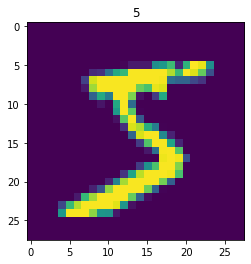

In [ ]:
def show_image(i):
    image = X_train_numpy[i]
    plt.imshow(image)
    plt.title(Y_train_numpy[i])
    plt.show()
show_image(0)

In [3]:
X_train = torch.div(torch.from_numpy(X_train_numpy).type(torch.FloatTensor), 127.5)[0:10000].cuda() - 1
X_train = X_train.view(10000, 1, 28, 28)
# X_test = torch.div(torch.from_numpy(X_test_numpy).type(torch.FloatTensor), 127.5).cuda() - 1
Y_train = torch.from_numpy(Y_train_numpy).type(torch.long)[0:10000].cuda()
# Y_test = torch.from_numpy(Y_test_numpy).type(torch.long).cuda()

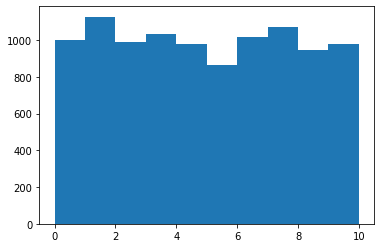

In [ ]:
plt.hist(Y_train_numpy[0:10000], bins = [0,1,2,3,4,5,6,7,8,9,10]) 
plt.show()

Discriminator
====================

In [4]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(OrderedDict([
            # hidden layer 1
            ('fc1', nn.Linear(28 * 28, 1024)),
            ('rl1', nn.LeakyReLU(0.2)),
            ('dt1', nn.Dropout(0.2)),

            # hidden layer 2
            ('fc2', nn.Linear(1024, 512)),
            ('rl2', nn.LeakyReLU(0.2)),
            ('dt2', nn.Dropout(0.2)),

            # hidden layer 3
            ('fc3', nn.Linear(512, 256)),
            ('rl3', nn.LeakyReLU(0.2)),
            ('dt3', nn.Dropout(0.2))
        ]))

        self.adv_layer \
            = nn.Sequential(nn.Linear(256, 1), nn.Sigmoid())
        self.aux_layer \
            = nn.Sequential(nn.Linear(256, label_classes), nn.Softmax(dim=1))
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = self.model(x) # 256
        validity = self.adv_layer(x)
        label = self.aux_layer(x)
        return validity, label

Generator
================
input: use labels set to ignite whose size is (N).  
Then in the dictionary, it will retrieve corresponded vectors and mix with noise.

output: image

In [5]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # generate the dictionary, each line stands for a label vectors
        self.label_emb = nn.Embedding(label_classes, 100) # (label_classes, dim) 

        self.model = nn.Sequential(OrderedDict([
            # hidden layer 1
            ('fc1', nn.Linear(100, 256)),
            ('rl1', nn.LeakyReLU(0.2)),

            # hidden layer 2
            ('fc2', nn.Linear(256, 512)),
            ('rl2', nn.LeakyReLU(0.2)),

            # hidden layer 3
            ('fc3', nn.Linear(512, 1024)),
            ('rl3', nn.LeakyReLU(0.2)),

            # out layer
            ('fc4', nn.Linear(1024, 28 * 28)),
            ('th1', nn.Tanh())
        ]))

    def vec2img(self, x):
        return x.view(x.size()[0], 1, 28, 28)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        x = torch.mul(self.label_emb(x), 
                torch.cuda.FloatTensor(
                    np.random.normal(0, 1, 
                        (x.size()[0], 100)))) # add noise, size = (batch, latent_dim)
        x = self.model(x)
        x = self.vec2img(x)
        return x

Implement
=========================

parameters
----------------

In [7]:
epochs = 20000
label_classes = 10

instance
---------------

In [8]:
discriminator = Discriminator().cuda()
generator = Generator().cuda()
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002)
generator_optimizer = optim.Adam(generator.parameters(), lr = 0.0002)

loss function
---------------------

In [9]:
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()

execute
-----------------

In [10]:
def show_generate_image(x_torch, label_torch):
    x = x_torch[0:8, 0:1, 0:28, 0:28].cpu().detach().numpy().reshape((8, 28, 28))
    fig, ax = plt.subplots(1, 8, figsize=(17,17))
    for i, img in enumerate(x):
        ax[i].imshow(img)
        ax[i].set_title(f"{label_torch[i].item()}")
    plt.show()

epoch is 499: discriminator loss is         0.9677473306655884, generator loss is 1.5525615215301514


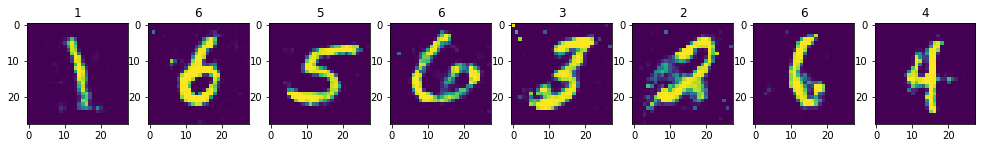

epoch is 999: discriminator loss is         0.9621036052703857, generator loss is 1.6081722974777222


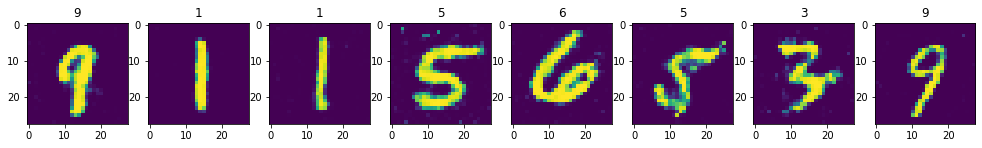

epoch is 1499: discriminator loss is         0.9639339447021484, generator loss is 1.6275570392608643


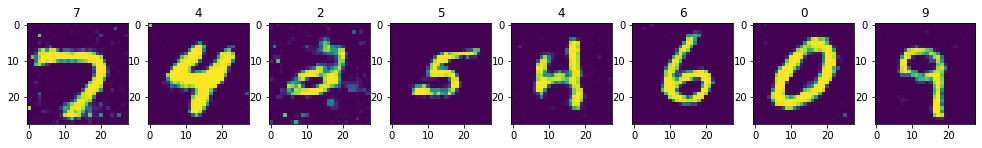

epoch is 1999: discriminator loss is         0.9652186632156372, generator loss is 1.5887115001678467


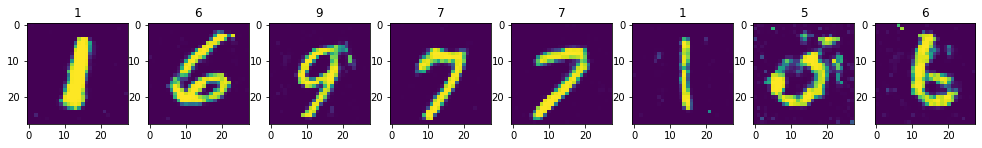

epoch is 2499: discriminator loss is         0.962745726108551, generator loss is 1.6159768104553223


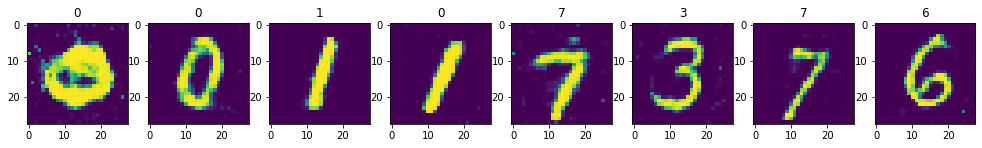

epoch is 2999: discriminator loss is         0.9691848158836365, generator loss is 1.6206848621368408


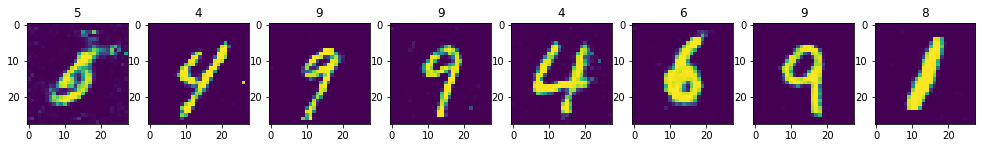

epoch is 3499: discriminator loss is         0.9499516487121582, generator loss is 1.5719687938690186


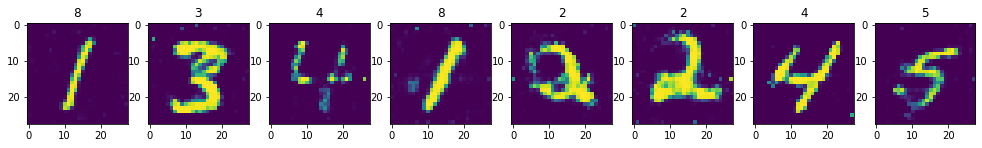

epoch is 3999: discriminator loss is         0.9480821490287781, generator loss is 1.7203114032745361


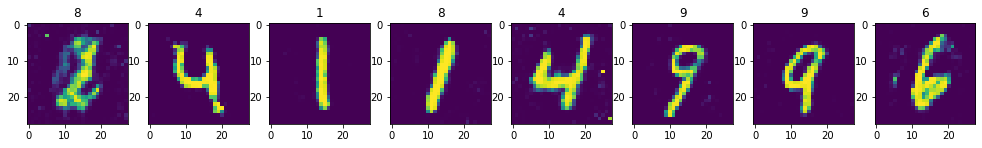

epoch is 4499: discriminator loss is         0.9497655630111694, generator loss is 1.8006657361984253


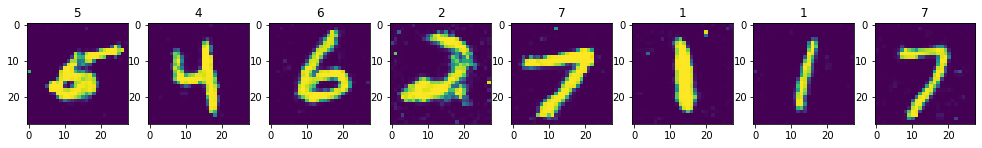

epoch is 4999: discriminator loss is         0.946157693862915, generator loss is 1.6415534019470215


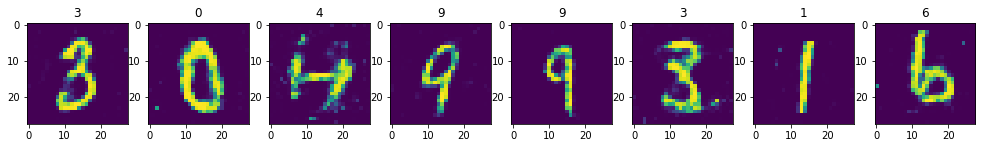

epoch is 5499: discriminator loss is         0.9469141960144043, generator loss is 1.713688850402832


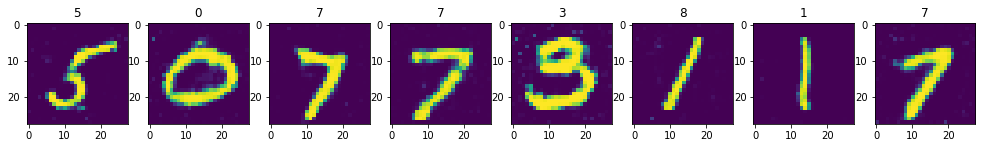

epoch is 5999: discriminator loss is         0.9490786790847778, generator loss is 1.639826774597168


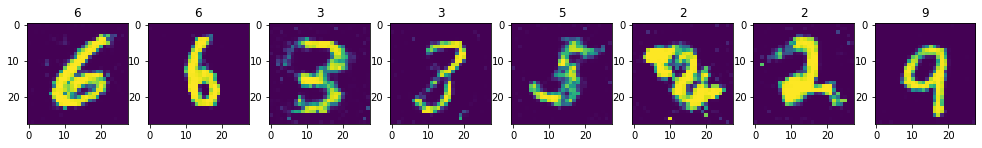

epoch is 6499: discriminator loss is         0.9438517093658447, generator loss is 1.7602620124816895


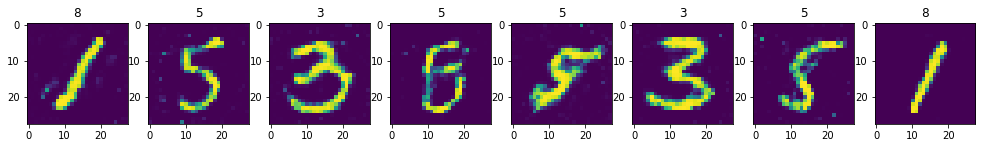

epoch is 6999: discriminator loss is         0.9443224668502808, generator loss is 1.7581818103790283


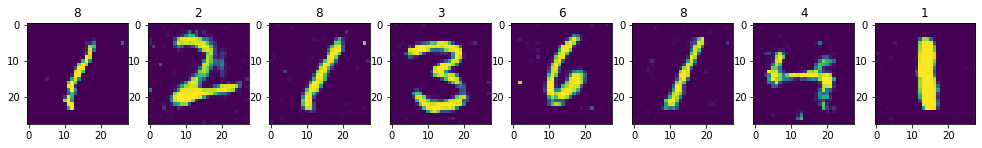

epoch is 7499: discriminator loss is         0.9406890869140625, generator loss is 1.800635576248169


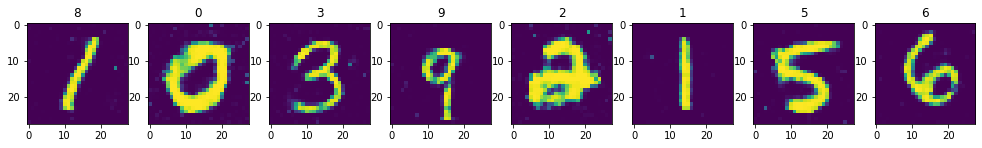

epoch is 7999: discriminator loss is         0.9435649514198303, generator loss is 1.6895701885223389


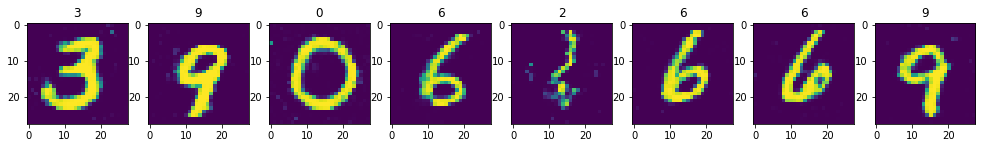

epoch is 8499: discriminator loss is         0.9319692850112915, generator loss is 1.7406384944915771


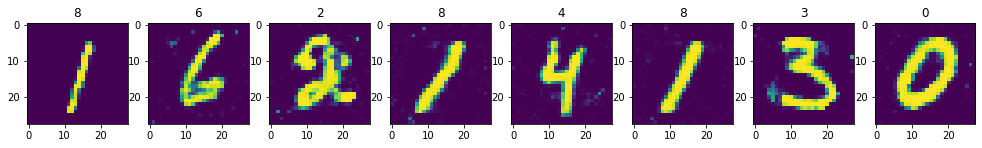

epoch is 8999: discriminator loss is         0.9339773058891296, generator loss is 1.8303203582763672


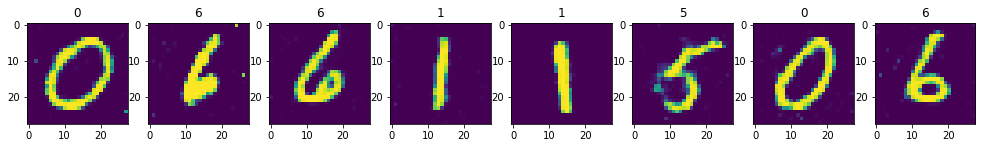

epoch is 9499: discriminator loss is         0.9345844984054565, generator loss is 1.6900708675384521


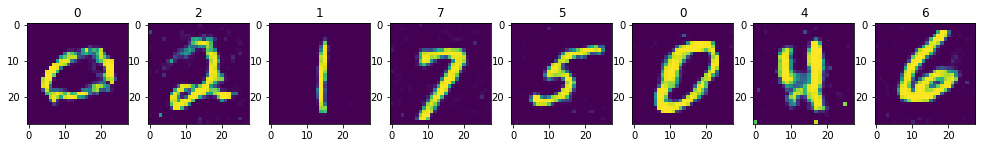

epoch is 9999: discriminator loss is         0.926749587059021, generator loss is 1.8295807838439941


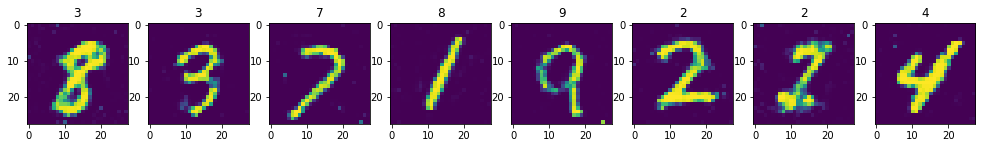

epoch is 10499: discriminator loss is         0.925927996635437, generator loss is 1.839613437652588


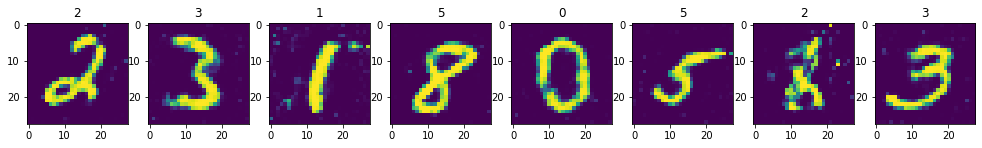

epoch is 10999: discriminator loss is         0.9145607948303223, generator loss is 1.942109227180481


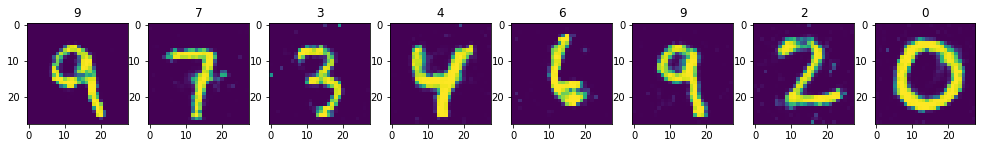

epoch is 11499: discriminator loss is         0.9253025054931641, generator loss is 1.9768719673156738


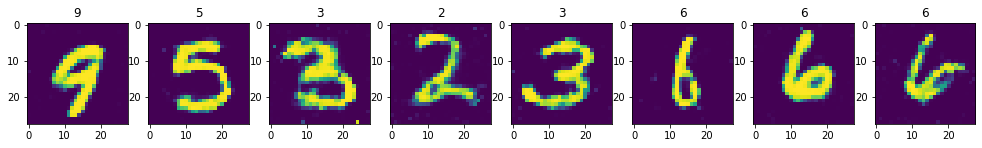

epoch is 11999: discriminator loss is         0.9197226166725159, generator loss is 1.7688019275665283


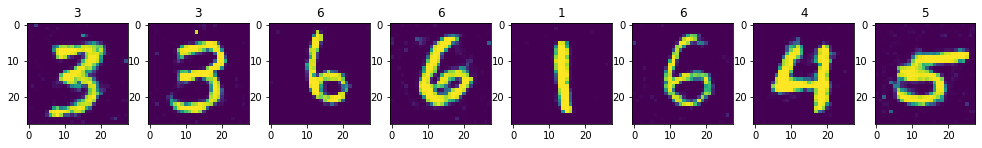

epoch is 12499: discriminator loss is         0.9167693257331848, generator loss is 1.959593653678894


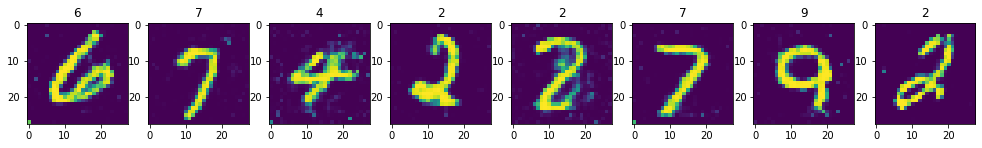

epoch is 12999: discriminator loss is         0.9123072624206543, generator loss is 1.8494716882705688


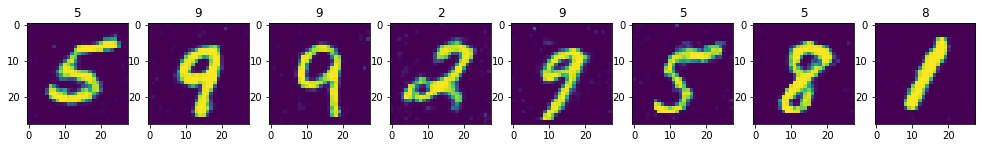

epoch is 13499: discriminator loss is         0.9127807021141052, generator loss is 1.897021770477295


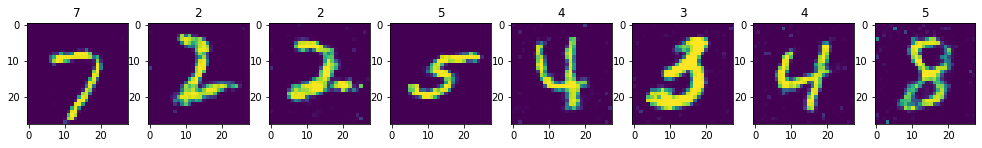

epoch is 13999: discriminator loss is         0.9101442098617554, generator loss is 1.9474457502365112


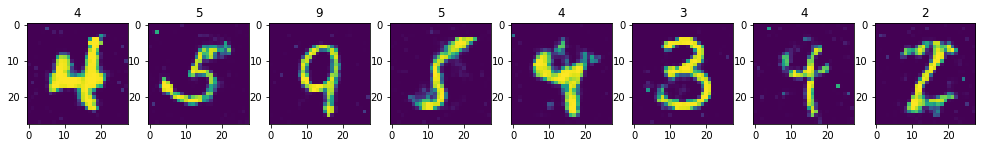

epoch is 14499: discriminator loss is         0.9088510274887085, generator loss is 1.9432029724121094


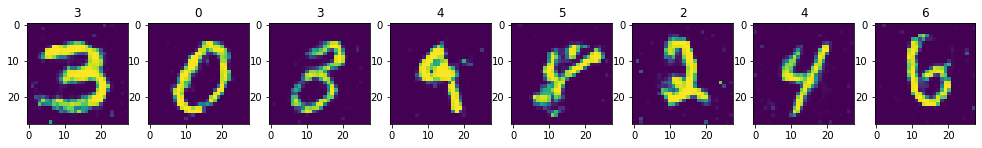

epoch is 14999: discriminator loss is         0.9069007635116577, generator loss is 1.9263997077941895


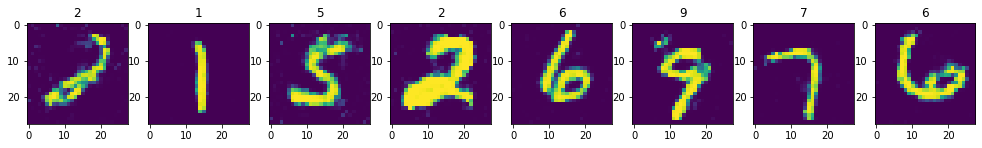

epoch is 15499: discriminator loss is         0.9064086079597473, generator loss is 1.9775819778442383


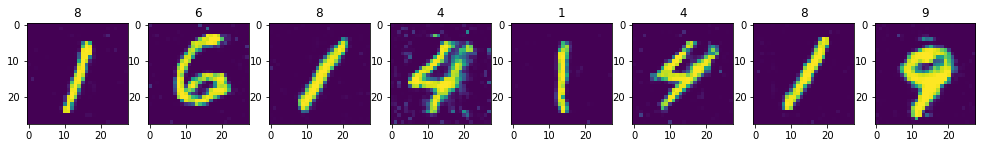

epoch is 15999: discriminator loss is         0.9038382768630981, generator loss is 1.8370306491851807


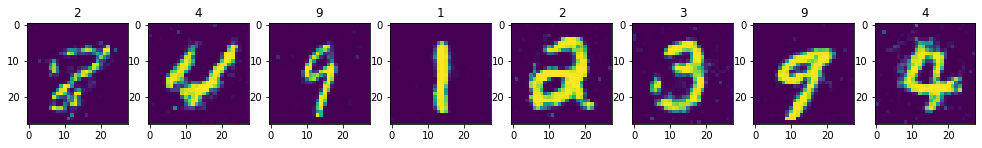

epoch is 16499: discriminator loss is         0.9051522016525269, generator loss is 1.9823715686798096


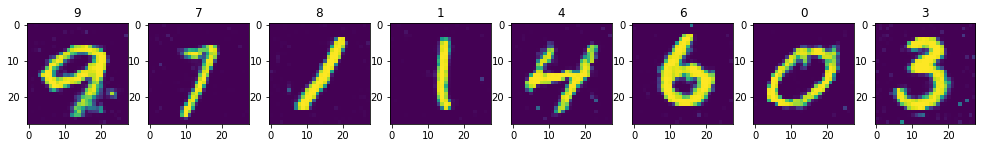

epoch is 16999: discriminator loss is         0.8971980810165405, generator loss is 1.9570893049240112


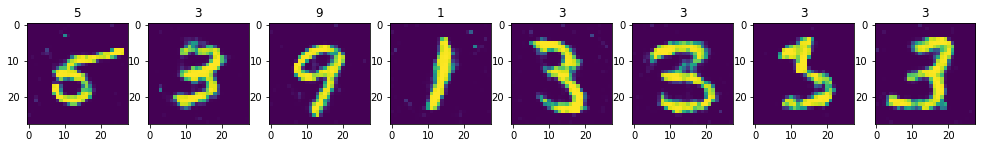

epoch is 17499: discriminator loss is         0.8959511518478394, generator loss is 1.984969973564148


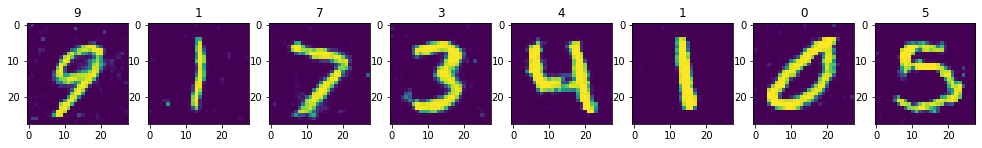

epoch is 17999: discriminator loss is         0.8991498947143555, generator loss is 1.8886003494262695


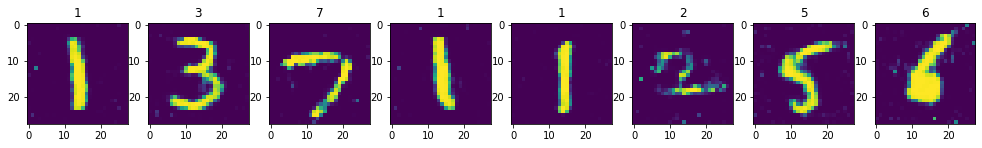

epoch is 18499: discriminator loss is         0.8990770578384399, generator loss is 1.9843237400054932


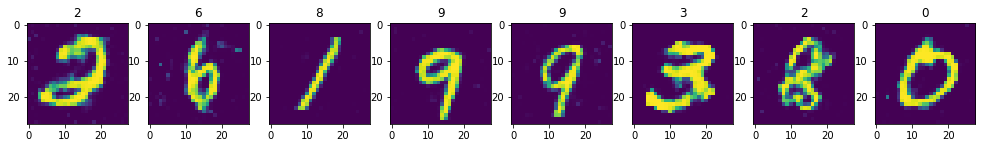

epoch is 18999: discriminator loss is         0.8906883001327515, generator loss is 2.023601770401001


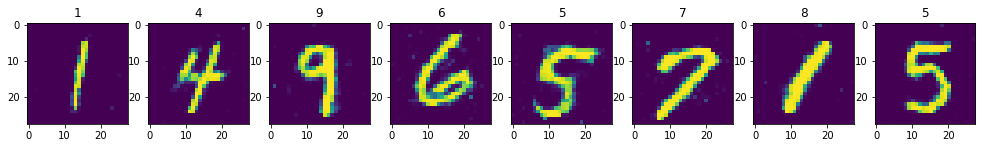

epoch is 19499: discriminator loss is         0.8906670212745667, generator loss is 2.0621449947357178


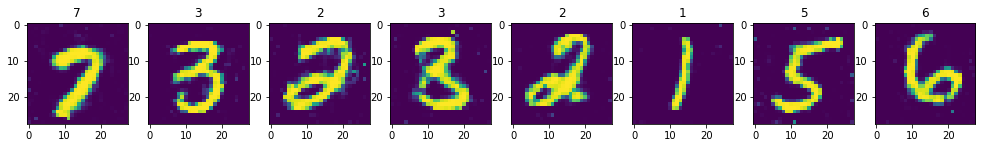

epoch is 19999: discriminator loss is         0.8940184116363525, generator loss is 2.1196188926696777


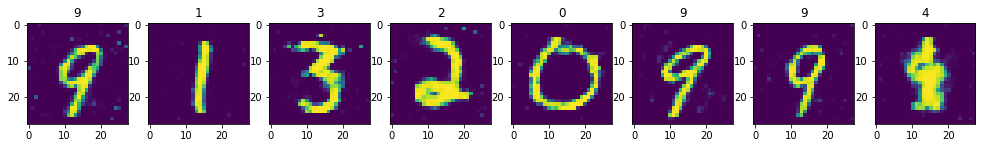

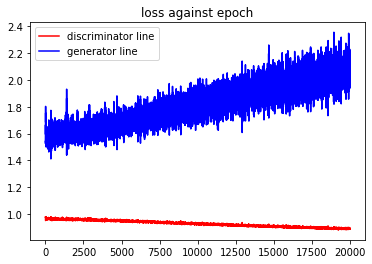

In [12]:
from tqdm.notebook import tnrange, tqdm_notebook

epoch_list = []
d_loss_list = []
g_loss_list = []
N = X_train.size()[0] # number of all train image


for epoch in tnrange(epochs):
    
    # feed generator with noise
    gen_labels = Variable(torch.cuda.LongTensor(np.random.randint(0, label_classes, N))).cuda()
    fake = generator(gen_labels) # fake is a image
    
    # train discriminator
    # train real data
    discriminator_optimizer.zero_grad()
    real_pred, real_aux = discriminator(X_train) 
    loss_real = (adversarial_loss(real_pred, torch.ones(N, 1).cuda())
            + auxiliary_loss(real_aux, Y_train)) / 2
    # train fake data
    fake_pred, fake_aux = discriminator(fake.detach())
    loss_fake = (adversarial_loss(fake_pred, torch.zeros(N, 1).cuda())
            + auxiliary_loss(fake_aux, gen_labels)) / 2
    loss_d = (loss_real + loss_fake) / 2
    loss_d.backward()
    discriminator_optimizer.step()

    # train generator
    generator_optimizer.zero_grad()
    val, l = discriminator(fake)
    loss_g = (adversarial_loss(val, torch.ones(N, 1).cuda())
            + auxiliary_loss(l, gen_labels)) / 2
    loss_g.backward()
    generator_optimizer.step()

    epoch_list.append(epoch)
    d_loss_list.append(loss_d.item())
    g_loss_list.append(loss_g.item())

    if (epoch + 1) % 500 == 0:
        print(f"epoch is {epoch}: discriminator loss is \
        {loss_d.item()}, generator loss is {loss_g.item()}")
        show_generate_image(fake, gen_labels)
    

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=d_loss_list, color='red', label='discriminator line', ax=ax)
sns.lineplot(x=epoch_list, y=g_loss_list, color='blue', label='generator line', ax=ax)
plt.title(f"loss against epoch")
plt.show()


generate images
----------------------

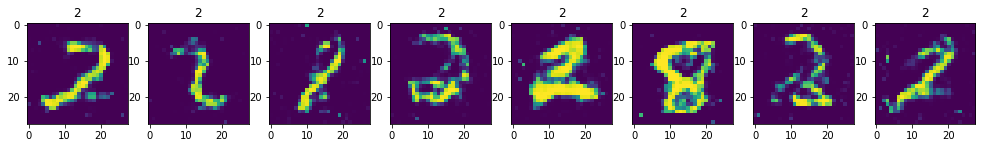

In [106]:
labels = torch.LongTensor([[0, 0, 0, 0, 0, 0, 0, 0],
                          [1, 1, 1, 1, 1, 1, 1, 1],
                          [2, 2, 2, 2, 2, 2, 2, 2],
                          [3, 3, 3, 3, 3, 3, 3, 3],
                          [4, 4, 4, 4, 4, 4, 4, 4],
                          [5, 5, 5, 5, 5, 5, 5, 5],
                          [6, 6, 6, 6, 6, 6, 6, 6],
                          [7, 7, 7, 7, 7, 7, 7, 7],
                          [8, 8, 8, 8, 8, 8, 8, 8],
                          [9, 9, 9, 9, 9, 9, 9, 9]]).cuda()
label = labels[2]
fake = generator(label) # fake is a image
show_generate_image(fake, label)

Report
==================

1.   This model can't generate 8 very well, all expected 8 are generated as 1
2.   Here are lots of 8 hidden in 5 and 3, few in 2
3.   Other numbers

